In [1]:
from dotenv import load_dotenv
load_dotenv()

import os 
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

### How to use chat messages as our graph state

In [6]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Anay"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn Python Programming language",name="Anay"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Anay

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Anay

I want to learn Python Programming language


### Chat Models

In [8]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-120b")
result=llm.invoke(messages)

In [9]:
result.response_metadata

{'token_usage': {'completion_tokens': 3534,
  'prompt_tokens': 113,
  'total_tokens': 3647,
  'completion_time': 7.28891023,
  'completion_tokens_details': {'reasoning_tokens': 29},
  'prompt_time': 0.004489343,
  'prompt_tokens_details': None,
  'queue_time': 0.055492257,
  'total_time': 7.293399573},
 'model_name': 'openai/gpt-oss-120b',
 'system_fingerprint': 'fp_d29d1d1418',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

### How to integrate Tools

In [13]:
def add(a:int,b:int)-> int:
    """
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [14]:
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000025752CA7D90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000025752CB07D0>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [20]:
### Binding tool with LLM

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"Use the add function to calculate the sum of 2 and 2",name="Anay")])

In [21]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'fc_9328e7ef-8396-4963-bf58-7105d5b2fbbd',
  'type': 'tool_call'}]

In [37]:
### using messages as state
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


In [66]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [39]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Anay"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Anay')]

In [40]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [41]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='55c00fb8-3c9d-42e4-9c90-e95c9de6c432'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Anay', id='96412053-2f33-4835-befb-7eaf6b12a4e5'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='a83819a3-33cf-46da-9257-d7b8b9321154')]

In [67]:
## Chatbot node functionality
def llm_tool(state:State):
    return {
        "messages":[
            llm_with_tools.invoke(state["messages"])
            ]
        }

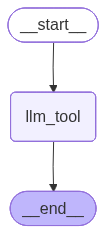

In [68]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
## invocation
messages=graph.invoke({"messages":"Use add function to find the sum of 2 and 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Use add function to find the sum of 2 and 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_88ab2b1e-fdd5-42eb-bfcf-b9cf59354995)
 Call ID: fc_88ab2b1e-fdd5-42eb-bfcf-b9cf59354995
  Args:
    a: 2
    b: 2


In [70]:
tools=[add]

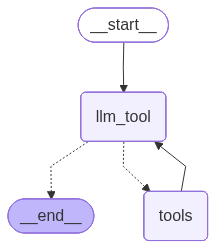

In [71]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder=StateGraph(State)

## Add nodes
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    ## If the latest message {result} from assistant is a tool call -> tools_condition routes to tools
    ## If the latest message {result} from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","llm_tool")

graph_builder=builder.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [74]:
## invocation
messages=graph_builder.invoke({"messages":"Use add function to find the sum of 2 and 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Use add function to find the sum of 2 and 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_45a5edb1-01a9-47d7-ba55-fb9b39d004cf)
 Call ID: fc_45a5edb1-01a9-47d7-ba55-fb9b39d004cf
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4
================================== Ai Message ==================================

The sum of 2 and 2 is **4**.
